In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import torch 

In [4]:
# A class to control action/state for contextual bandit problem
class ContextBandit:
    def __init__(self, num_arms=10, max_dollar = 10):
        self.num_arms = num_arms
        self.max_dollar = max_dollar
        self.initialize_distribution(num_arms)
        self.update_state()
        
    def initialize_distribution(self, num_arms):
        self.bandit_matrix = np.random.rand(num_arms, num_arms) # State X Action matrix

    def reward(self, prob):
        reward = 0
        for _ in range(self.max_dollar):
            if np.random.rand() < prob:
                reward += 1
        return reward

    def get_state(self):
        return self.state

    def update_state(self):
        self.state = np.random.randint(0, self.num_arms)

    def get_reward(self, action):
        return self.reward(self.bandit_matrix[self.get_state()][action])

    def choose_arm(self, action):
        reward = self.get_reward(action)
        self.update_state()
        return reward

CB = ContextBandit(num_arms=10, max_dollar=10)

### Train a MLP to learn the bandit matrix
     Network Input:  Current state
     Network Output: Estimation of reward
     Sample action from the estimated reward then perform the action and compare the actual reward with the predicted one for training

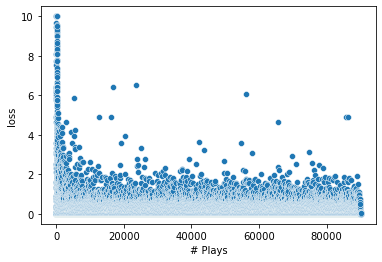

In [49]:
num_arms = 10
max_dollar = 10

D_in, H, D_out = num_arms, 100, num_arms

model = torch.nn.Sequential(
torch.nn.Linear(D_in, H),
torch.nn.ReLU(),
torch.nn.Linear(H, D_out),
torch.nn.ReLU(),
)

loss_fn = torch.nn.MSELoss()

env = ContextBandit(num_arms, max_dollar)

def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec
# Softmax function
def softmax(values, T=1):
    return np.exp(values/T) / np.sum(np.exp(values/T))


# Train the model
def train(env, epoch = 5000, lr = 1e-1):
    current_state = torch.Tensor(one_hot(env.num_arms, env.get_state()))
    opt = torch.optim.Adam(model.parameters(), lr = lr)
    reward = []
    training_loss = np.zeros((epoch,))
    for ep in range(epoch):
        y_pred = model(current_state)
        prob = softmax(y_pred.data.numpy(), T=1)
        # Take an action based on predicted prob
        action = np.random.choice(env.num_arms, p=prob)
        current_reward = env.choose_arm(action)
        reward.append(current_reward)
        # Convert reward to one hot
        reward_one_hot = y_pred.data.numpy().copy()
        #reward_one_hot = env.bandit_matrix[env.get_state(), :]
        reward_one_hot[action] = current_reward
        reward_one_hot = torch.Tensor(reward_one_hot)

        loss = loss_fn(y_pred, reward_one_hot)
        training_loss[ep] = loss.data.numpy().copy()
        opt.zero_grad()
        loss.backward()
        opt.step()
        # Update current state
        current_state = torch.Tensor(one_hot(env.num_arms, env.get_state()))
    return reward, training_loss

num_epoch = 90000
learning_rate = 1e-3
rewards, training_loss = train(env, num_epoch, lr=learning_rate)

sb.scatterplot(x=np.arange(num_epoch), y=training_loss)
plt.xlabel("# Plays")
plt.ylabel("loss")
plt.show()

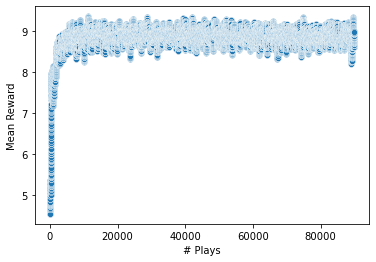

In [50]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

smooth_reward = moving_average(rewards, w=100)

sb.scatterplot(x=np.arange(len(smooth_reward)), y=smooth_reward)
plt.xlabel("# Plays")
plt.ylabel("Mean Reward")
plt.show()

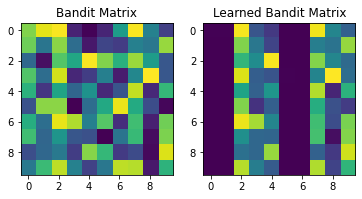

In [61]:
estimated_bandit_matrix = np.zeros((env.num_arms, env.num_arms))

for st in range(env.num_arms):
    state = torch.Tensor(one_hot(env.num_arms, st))
    reward_pred = model(state)
    #prob = softmax(reward_pred.data.numpy(), T=1)
    estimated_bandit_matrix[st, :] = reward_pred.data.numpy()


plt.subplot(1,2,1)
plt.imshow(env.bandit_matrix)
plt.title('Bandit Matrix')
plt.subplot(1,2,2)
plt.imshow(estimated_bandit_matrix)
plt.title('Learned Bandit Matrix')
plt.show()